In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:30, 1339.91it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

Часть 1. Анализ текстов [40/100]

    Посчитайте количество отзывов в разных городах и на разные банки
    Постройте гистограмы длин слов в символах и в словах
    Найдите 10 самых частых:
        слов
        слов без стоп-слов
        лемм
    существительных
    Постройте кривые Ципфа и Хипса
    Ответьте на следующие вопросы:
        какое слово встречается чаще, "сотрудник" или "клиент"?
        сколько раз встречается слова "мошенничество" и "доверие"?
    В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf−idftf−idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)



In [5]:
r=responses[999]

In [6]:
r['author']

'steelrat'

In [7]:
responses[999]

{'author': 'steelrat',
 'bank_license': 'лицензия № 1326',
 'bank_name': 'Альфа-Банк',
 'city': 'г. Москва',
 'datetime': '2015-05-26 21:47:41',
 'num_comments': 5,
 'rating_grade': None,
 'rating_not_checked': False,
 'text': 'Этот \xa0банк не чурается угрозами личной жизни. Ранее в этом банке был выдан кредит безответсвенному человеку. Эта личность продала квартиру, и выписалась в неизвестном направлении. Сейчас банк названивает и угрожает выбить дверь и произвести вынос имущества у нас, которые к этой гражданке не имеют отношения. В качестве контакта указан номер 8-903-254-**-43.\xa0На ответный звонок этот вышибала подтвердил, что будет вызвана оперативная группа. По данному делу мы подаем заявление в милицию. Сам банк даже не удосужился произвести внутренние расследование или обратиться в официальные органы!',
 'title': 'Вышибалы по вызову'}

### Количество отзывов о банках в разрезе городов

In [33]:
banks={}
cities={}

for response in responses:
    bank=response['bank_name']
    city=response['city']
    if cities.get(city, 0)!=0:
        banks=cities[city]
    else:
        banks={}
    banks[bank]=banks.get(bank, 0)+1
    cities[city]=banks


In [34]:
for city in cities:
    print(city)
    b=cities[city]
    print('--------------------')
    for bank in b:
        print(bank, ':', b[bank])

г. Москва
--------------------
Бинбанк : 566
Гагаринский : 18
Тинькофф Банк : 2339
Альфа-Банк : 3871
Совкомбанк : 338
Московский Кредитный Банк : 2348
Сбербанк России : 8146
ВТБ 24 : 2714
Бенифит-Банк : 108
Уральский Банк Реконструкции и Развития : 42
БИНБАНК кредитные карты : 384
Хоум Кредит Банк : 2143
МДМ Банк : 212
Киви Банк : 710
Русславбанк : 279
МАСТ-Банк : 150
Национальный Банк «Траст» : 1654
Связной Банк : 1408
Московский Индустриальный Банк : 96
Восточный Экспресс Банк : 401
Финансовый Стандарт : 101
Русский Стандарт : 2801
ЮниКредит Банк : 1169
Банкирский Дом : 20
Кредит Европа Банк : 598
Тройка-Д Банк : 13
ДельтаКредит : 281
Ханты-Мансийский банк Открытие : 626
ФК Открытие (бывш. НОМОС-Банк) : 224
Банк Москвы : 1285
Росбанк : 575
Авангард : 1060
Росэнергобанк : 42
Российский Капитал : 63
РосинтерБанк : 312
Российский Кредит : 80
Европлан Банк : 110
Адамон Банк : 3
РосЕвроБанк : 171
Райффайзенбанк : 1426
Нота-Банк : 10
АйМаниБанк : 427
Югра : 250
Ренессанс Кредит : 1213
Объе

Газпромбанк : 4
Российский Капитал : 6
Авангард : 1
Форштадт : 1
Связь-Банк : 2
Банк ИТБ : 19
Абсолют Банк : 6
Банк Москвы : 9
БИНБАНК кредитные карты : 2
Московский Областной Банк : 4
Уралсиб : 11
2Т Банк : 3
СМП Банк : 12
БыстроБанк : 4
Европлан Банк : 1
Юниаструм Банк : 5
Снежинский : 1
Росгосстрах Банк : 4
Современный Коммерческий Банк (бывш. ДжиИ Мани Банк) : 14
Россельхозбанк : 2
Уралфинанс : 1
ТверьУниверсалБанк : 1
Союз : 2
Эксперт Банк : 1
Московский Кредитный Банк : 1
Мой Банк : 4
ФК Открытие (бывш. НОМОС-Банк) : 3
Смартбанк : 1
Агропромкредит : 2
Транснациональный Банк : 1
Кредит-Москва : 4
Углеметбанк : 1
Западный : 1
Пробизнесбанк : 1
Мастер-Банк : 1
ДельтаКредит : 3
Банк24.ру : 9
Бузулукбанк : 1
Транскредитбанк : 1
Экспресс-Волга : 1
Зенит : 2
Петрокоммерц : 1
Балтийский Банк : 1
Банк Сосьете Женераль Восток : 2
КИТ Финанс Инвестиционный Банк : 1
Лада-Кредит : 1
АФ Банк : 1
Северная Казна : 2
г. Волгоград
--------------------
Сбербанк России : 216
Уральский Банк Реконстру

Яндекс.Деньги : 2
ДельтаКредит : 5
Современный Коммерческий Банк (бывш. ДжиИ Мани Банк) : 30
Юниаструм Банк : 3
БИНБАНК кредитные карты : 19
2Т Банк : 7
Ланта-Банк : 1
Российский Кредит : 1
Меткомбанк (Череповец) : 1
Пойдем! : 2
Москоммерцбанк : 8
Союз : 2
Океан Банк : 6
Локо-Банк : 5
Агропромкредит : 1
Россельхозбанк : 3
РосЕвроБанк : 1
Петрокоммерц : 9
Эллипс Банк : 13
Саровбизнесбанк : 10
БНП Париба Банк : 9
Смартбанк : 3
Вокбанк : 3
Банк Жилищного Финансирования : 4
Дойче Банк : 1
Первый Республиканский Банк : 8
Плюс Банк : 1
Тусар : 1
Запсибкомбанк : 1
Рост Банк : 1
Межтопэнергобанк : 1
Связь-Банк : 2
Гута-Банк : 4
Таврический : 1
Кредит-Москва : 1
БКС — Инвестиционный Банк : 1
Транскредитбанк : 5
Интерпрогрессбанк : 1
Западный : 1
Финам Банк : 1
НС Банк : 3
Мастер-Банк : 1
Вятка-Банк : 1
Пушкино : 2
Транскапиталбанк : 1
Европейский Трастовый Банк : 4
ПК-Банк : 2
Банк Сосьете Женераль Восток : 3
Юнистрим : 1
Абсолют Банк : 1
Борский Коммерческий Банк : 1
АБ Финанс : 1
Зенит : 2
Ба

Ханты-Мансийский банк Открытие : 16
Плюс Банк : 6
Русславбанк : 5
Мираф-Банк : 3
Московский Областной Банк : 6
Абсолют Банк : 3
МДМ Банк : 8
Агросоюз : 1
Европлан Банк : 1
Запсибкомбанк : 1
Юниаструм Банк : 2
Газпромбанк : 6
СтарБанк : 2
Россельхозбанк : 2
СМП Банк : 2
Уралсиб : 8
Финам Банк : 2
РН Банк : 1
Банк Жилищного Финансирования : 1
Сибэс : 1
Экспобанк : 1
ФК Открытие (бывш. НОМОС-Банк) : 1
БНП Париба Банк : 2
Западный : 3
РосЕвроБанк : 1
СКБ-Банк : 5
БИНБАНК кредитные карты : 3
Единый Строительный Банк : 1
Транскредитбанк : 3
Кредит-Москва : 1
Ситибанк : 1
Мастер-Банк : 3
МАСТ-Банк : 1
КИТ Финанс Инвестиционный Банк : 3
Акцепт : 1
БКС — Инвестиционный Банк : 1
Москоммерцбанк : 2
Городской Ипотечный Банк : 1
Банк Интеза : 1
Сиббизнесбанк : 1
Росбанк : 1
Современный Коммерческий Банк (бывш. ДжиИ Мани Банк) : 1
г. Астрахань
--------------------
Киви Банк : 9
Тинькофф Банк : 14
ВТБ 24 : 21
Альфа-Банк : 9
Связной Банк : 10
Сбербанк России : 66
Экспресс-Волга : 2
Яндекс.Деньги : 1
О

Восточный Экспресс Банк : 2
Райффайзенбанк : 3
АйМаниБанк : 3
Хоум Кредит Банк : 11
Экспресс-Волга : 2
Русский Стандарт : 6
Национальный Банк «Траст» : 5
Яндекс.Деньги : 1
Связной Банк : 8
МТС Банк : 4
Фора-Банк : 1
Ренессанс Кредит : 5
Сетелем Банк : 4
Бинбанк : 3
Ак Барс : 2
Московский Областной Банк : 5
Альфа-Банк : 5
Европлан Банк : 3
ВТБ 24 : 9
Киви Банк : 1
ЮниКредит Банк : 2
Русславбанк : 1
Океан Банк : 1
Смартбанк : 2
Кредит Европа Банк : 1
Агросоюз : 1
Росбанк : 2
КС Банк : 1
Мастер-Банк : 1
ОТП Банк : 2
Межрегиональный промышленно-строительный банк : 1
Возрождение : 1
Русфинанс Банк : 1
г. Иваново
--------------------
Русфинанс Банк : 6
Связной Банк : 20
Национальный Банк «Траст» : 24
Лето Банк : 10
Альфа-Банк : 9
ОТП Банк : 8
БИНБАНК кредитные карты : 28
Росбанк : 8
ВТБ 24 : 21
Московский Областной Банк : 5
Тинькофф Банк : 21
Восточный Экспресс Банк : 7
Сбербанк России : 87
Русский Стандарт : 24
Авангард : 5
Юниаструм Банк : 6
Пробизнесбанк : 15
Райффайзенбанк : 6
Иваново : 

Уралсиб : 3
Росгосстрах Банк : 1
Рост Банк : 1
Ренессанс Кредит : 1
Национальный Банк «Траст» : 2
РосЕвроБанк : 1
ОТП Банк : 2
Авангард : 4
Кредит-Москва : 1
Инвестиционный Республиканский Банк : 1
ЮниКредит Банк : 4
Ханты-Мансийский банк Открытие : 2
Навигатор : 1
Росбанк : 4
Банк Проектного Финансирования : 2
Абсолют Банк : 1
Русский Стандарт : 1
Современный Коммерческий Банк (бывш. ДжиИ Мани Банк) : 1
Союз : 1
МТС Банк : 1
Связной Банк : 1
Совкомбанк : 1
Западный : 2
СБ Банк (Судостроительный банк) : 1
ДельтаКредит : 1
БНП Париба Банк : 1
Империя : 1
Соцгорбанк : 1
Юниаструм Банк : 1
г. Ноябрьск
--------------------
Национальный Банк «Траст» : 1
Ханты-Мансийский банк Открытие : 4
Югра : 1
Русский Стандарт : 1
Восточный Экспресс Банк : 1
Киви Банк : 3
Альфа-Банк : 1
Юнистрим : 1
Ренессанс Кредит : 1
Запсибкомбанк : 1
ОТП Банк : 2
МТС Банк : 1
Сбербанк России : 8
Газпромбанк : 3
Русфинанс Банк : 1
г. Арзамас
--------------------
Московский Областной Банк : 3
Сбербанк России : 13
Связн

Меткомбанк (Каменск-Уральский) : 1
Русфинанс Банк : 1
Европейский Трастовый Банк : 2
Петрокоммерц : 3
Кредит-Москва : 2
Пойдем! : 2
Банк Москвы : 1
Транскредитбанк : 2
Кредит Европа Банк : 1
РосЕвроБанк : 1
г. Нижневартовск (Ханты-Мансийский АО)
--------------------
Совкомбанк : 1
Сбербанк России : 1
г. Новотроицк
--------------------
Сбербанк России : 9
Агропромкредит : 1
Совкомбанк : 1
Сетелем Банк : 2
Экспресс-Волга : 2
Тинькофф Банк : 1
Банк Москвы : 1
Альфа-Банк : 5
Русский Стандарт : 2
Хоум Кредит Банк : 2
ОТП Банк : 2
г. Красногорск
--------------------
Альфа-Банк : 14
Сбербанк России : 41
Промсвязьбанк : 9
МТС Банк : 4
Промышленно-Финансовое Сотрудничество : 1
Ханты-Мансийский банк Открытие : 2
АйМаниБанк : 1
Возрождение : 6
Военно-Промышленный Банк : 1
Национальный Банк «Траст» : 1
Русфинанс Банк : 1
Сетелем Банк : 1
Райффайзенбанк : 3
Югра : 1
Киви Банк : 1
Ренессанс Кредит : 2
Альта-Банк : 1
Московский Областной Банк : 6
Ситибанк : 1
Хоум Кредит Банк : 8
Тинькофф Банк : 5
ОТ

ОПМ-Банк : 2
Бинбанк : 1
ОТП Банк : 2
СтарБанк : 1
Банк Москвы : 3
Росбанк : 1
Национальный Банк «Траст» : 1
Сетелем Банк : 2
Клиентский : 2
Русский Стандарт : 2
Московский Областной Банк : 5
Восточный Экспресс Банк : 1
МТС Банк : 1
Альфа-Банк : 3
Киви Банк : 1
РосинтерБанк : 2
Ренессанс Кредит : 1
Кредит-Москва : 1
Тусар : 1
Промсвязьбанк : 1
Авангард : 1
Союз : 1
Связной Банк : 3
Пробизнесбанк : 1
ФК Открытие (бывш. НОМОС-Банк) : 1
г. Сызрань
--------------------
Сбербанк России : 13
Национальный Банк «Траст» : 7
Ренессанс Кредит : 1
Росбанк : 3
Восточный Экспресс Банк : 2
ВТБ 24 : 8
ОТП Банк : 1
Альфа-Банк : 3
МТС Банк : 1
Тинькофф Банк : 2
Киви Банк : 3
Ханты-Мансийский банк Открытие : 2
Россельхозбанк : 2
Банк АВБ : 3
Сетелем Банк : 1
Хоум Кредит Банк : 4
Русский Стандарт : 4
Транскредитбанк : 1
Связной Банк : 2
Солидарность (Самара) : 1
Земский Банк : 1
СКБ-Банк : 1
Русфинанс Банк : 1
г. Новый Уренгой
--------------------
Сбербанк России : 9
Русский Стандарт : 3
СКБ-Банк : 2
Вост

Русский Стандарт : 1
ОТП Банк : 1
г. Дмитров
--------------------
Национальный Банк «Траст» : 3
Сбербанк России : 16
Альфа-Банк : 7
Инвестторгбанк : 2
Московский Областной Банк : 3
Русский Стандарт : 4
2Т Банк : 1
Кредит Европа Банк : 2
Тинькофф Банк : 6
НС Банк : 1
АйМаниБанк : 3
Лето Банк : 2
ОТП Банк : 1
Ситибанк : 3
Банк Москвы : 1
Хоум Кредит Банк : 2
Советский : 1
Восточный Экспресс Банк : 2
Райффайзенбанк : 1
Россельхозбанк : 2
Ренессанс Кредит : 3
Сетелем Банк : 1
ВТБ 24 : 4
ФК Открытие (бывш. НОМОС-Банк) : 1
Связной Банк : 2
Мастер-Банк : 1
г. Ногинск (Московская обл.)
--------------------
Сбербанк России : 2
Восточный Экспресс Банк : 1
г. Старый Оскол (Белгородская обл.)
--------------------
Пробизнесбанк : 2
Национальный Банк «Траст» : 2
г. Борзя
--------------------
Хоум Кредит Банк : 2
ВТБ 24 : 1
Сбербанк России : 1
Азиатско-Тихоокеанский Банк : 1
г. Лениногорск
--------------------
АйМаниБанк : 2
Сетелем Банк : 1
МТС Банк : 1
Сбербанк России : 3
Промсвязьбанк : 1
Связной 

Кредит-Москва : 1
Русский Стандарт : 12
Океан Банк : 1
Бинбанк : 5
Альфа-Банк : 8
Уральский Банк Реконструкции и Развития : 1
Тинькофф Банк : 8
Русфинанс Банк : 2
Национальный Банк «Траст» : 3
Юнистрим : 1
Ситибанк : 2
2Т Банк : 1
Советский : 2
Кредит Европа Банк : 6
Европлан Банк : 1
Русславбанк : 1
Нордеа Банк : 1
Восточный Экспресс Банк : 3
Пойдем! : 1
Татфондбанк : 1
Банк «Санкт-Петербург» : 2
Фининвест : 1
Экспобанк : 1
Таврический : 2
Сетелем Банк : 1
Балтийский Банк : 2
Глобэкс : 1
БИНБАНК кредитные карты : 1
Первый Республиканский Банк : 1
Московский Областной Банк : 1
г. Волжский (Волгоградская обл.)
--------------------
Экспресс-Волга : 1
Хоум Кредит Банк : 1
Лето Банк : 1
Русский Стандарт : 1
Бинбанк : 1
Сбербанк России : 1
г. клин
--------------------
Сбербанк России : 1
Альфа-Банк : 1
2Т Банк : 1
г. Шахты
--------------------
Сбербанк России : 20
Русский Стандарт : 5
Национальный Банк «Траст» : 2
АйМаниБанк : 3
Альфа-Банк : 4
Восточный Экспресс Банк : 5
Московский Индустри

Кредит Европа Банк : 3
Тинькофф Банк : 2
Росбанк : 1
Московский Кредитный Банк : 1
Транспортный : 1
Ситибанк : 1
г. Новое Девяткино
--------------------
Тинькофф Банк : 1
г. Находка
--------------------
Восточный Экспресс Банк : 7
Альфа-Банк : 8
Киви Банк : 2
Связной Банк : 2
Национальный Банк «Траст» : 3
Сбербанк России : 12
ВТБ 24 : 1
Азиатско-Тихоокеанский Банк : 1
Хоум Кредит Банк : 2
Ренессанс Кредит : 1
Уралсиб : 1
ОТП Банк : 4
Примсоцбанк : 2
Совкомбанк : 2
Русский Стандарт : 1
МТС Банк : 2
Петрокоммерц : 1
Тинькофф Банк : 3
Транскредитбанк : 1
Россельхозбанк : 1
г. Малаховка
--------------------
Авангард : 2
Хоум Кредит Банк : 2
Киви Банк : 1
ОТП Банк : 2
Сбербанк России : 11
ВТБ 24 : 1
Тинькофф Банк : 2
Русский Стандарт : 2
Московский Кредитный Банк : 1
Связной Банк : 1
Ханты-Мансийский банк Открытие : 2
МТС Банк : 2
Транспортный : 3
г. Жуков
--------------------
ОТП Банк : 1
Софрино : 1
Хоум Кредит Банк : 1
г. Кировская область
--------------------
Русский Стандарт : 1
г. Сал

Русфинанс Банк : 1
г. Иноземцево
--------------------
Лето Банк : 2
Связной Банк : 1
Ренессанс Кредит : 2
Русский Стандарт : 1
Национальный Банк «Траст» : 1
Сбербанк России : 2
Альфа-Банк : 1
г. п первомайский щекинский рн
--------------------
Сбербанк России : 1
г. Горно-Алтайск
--------------------
ОТП Банк : 3
Россельхозбанк : 2
Сбербанк России : 4
Альфа-Банк : 4
Ренессанс Кредит : 1
Русский Стандарт : 1
Хоум Кредит Банк : 1
Сетелем Банк : 1
Восточный Экспресс Банк : 1
Связной Банк : 1
Совкомбанк : 1
Тинькофф Банк : 1
г. Дедовск
--------------------
ОТП Банк : 1
Национальный Банк «Траст» : 1
Океан Банк : 1
Тинькофф Банк : 1
Хоум Кредит Банк : 1
Возрождение : 1
г. Усть-Кут (Иркутская обл.)
--------------------
Сбербанк России : 1
г. Усинск (Республика Коми)
--------------------
СКБ-Банк : 1
МТС Банк : 1
Ренессанс Кредит : 1
г. Нижний Новгород, пр.Гагарина, д.108
--------------------
Сбербанк России : 1
г. Окуловка
--------------------
Восточный Экспресс Банк : 2
ОТП Банк : 1
Сетелем 

Киви Банк : 1
г. Буй
--------------------
Росбанк : 1
Совкомбанк : 1
г. Кемерово (Кемерово)
--------------------
Совкомбанк : 1
г. Челябинск (Челябинская область)
--------------------
ФК Открытие (бывш. НОМОС-Банк) : 1
Хоум Кредит Банк : 1
Уралсиб : 1
г. Видное (Москва)
--------------------
Промсвязьбанк : 1
г. Омская область (Санкт-Петербург)
--------------------
Сбербанк России : 1
г. Новороссийск (Новороссийск)
--------------------
Хоум Кредит Банк : 1
г. Россия, Волгоград (Россия)
--------------------
Волга-Кредит : 1
г. Прохладный (Республика Кабардино-Балкария) (Нальчик)
--------------------
Тинькофф Банк : 1
г. Серовский район, п.Восточный (Серов)
--------------------
Восточный Экспресс Банк : 1
г. Москва (Зеленоград) (Москва)
--------------------
Московский Кредитный Банк : 1
г. Москва (Юбилейный)
--------------------
Авангард : 1
Сбербанк России : 1
г. Балакирево
--------------------
Альфа-Банк : 1
г. Краснодарский край (Омская область)
--------------------
Российский Капитал 

Совкомбанк : 1
г. Мытищи (Москва)
--------------------
Русский Стандарт : 1
Московский Кредитный Банк : 1
Огни Москвы : 1
г. Алапаевск
--------------------
МТС Банк : 1
Хоум Кредит Банк : 3
Альфа-Банк : 1
Сбербанк России : 2
СКБ-Банк : 1
г. Москва (Казань)
--------------------
МТС Банк : 1
г. Новороссийск (Москва)
--------------------
Хоум Кредит Банк : 1
г. Бугуруслан
--------------------
Современный Коммерческий Банк (бывш. ДжиИ Мани Банк) : 1
Экспресс-Волга : 1
Альфа-Банк : 1
г. Оренбург (Подольск)
--------------------
Уральский Банк Реконструкции и Развития : 1
г. Сургут ХМАО (Ставропольский край)
--------------------
Восточный Экспресс Банк : 1
г. Коломна (Москва и область)
--------------------
Хоум Кредит Банк : 1
Киви Банк : 1
Тинькофф Банк : 1
г. Брянск (Москва)
--------------------
ОТП Банк : 1
г. Армавир (Краснодарский край)
--------------------
Сбербанк России : 1
г. Дюртюли (Республика Башкортостан)
--------------------
Тинькофф Банк : 1
Хоум Кредит Банк : 1
г. Якутск (Якут

Экспресс-Волга : 1
г. Венев
--------------------
Московский Областной Банк : 1
Киви Банк : 1
Сбербанк России : 2
г. Одинцово (Москва и область)
--------------------
Тинькофф Банк : 2
Русславбанк : 1
г. Атюрьево
--------------------
Сбербанк России : 1
г. Тучково (Москва)
--------------------
Московский Областной Банк : 1
г. Северодонецк Украина
--------------------
Киви Банк : 1
г. Усолье
--------------------
Уральский Банк Реконструкции и Развития : 1
Бинбанк : 1
г. Орел (Болхов)
--------------------
Национальный Банк «Траст» : 1
г. Буздяк
--------------------
Уралсиб : 1
г. Москва и Хабаровск (Владивосток)
--------------------
Банк Москвы : 1
г. Хабаровск (Краснодар)
--------------------
Газпромбанк : 1
г. Артемовский
--------------------
Сбербанк России : 2
Альфа-Банк : 1
г. Целина
--------------------
Банк Москвы : 1
г. тавричанка (Владивосток)
--------------------
МТС Банк : 1
г. Кошки
--------------------
Сбербанк России : 2
г. Ахтубинск
--------------------
Хоум Кредит Банк : 1


ЮниКредит Банк : 3
Алеф-Банк : 1
Транскредитбанк : 1
Авангард : 1
Темпбанк : 1
г. ПЕрмь
--------------------
Ренессанс Кредит : 1
г. Санкт-Петербург.
--------------------
Ренессанс Кредит : 1
Локо-Банк : 1
Русский Стандарт : 1
Ханты-Мансийский банк Открытие : 1
Транскредитбанк : 1
ВТБ 24 : 1
АМТ Банк : 1
г. Калужская обл.
--------------------
Киви Банк : 1
г. чебоксары
--------------------
Русский Стандарт : 1
Сетелем Банк : 1
Кредит Европа Банк : 1
ВТБ 24 : 1
Тинькофф Банк : 1
МТС Банк : 1
Хоум Кредит Банк : 1
Пробизнесбанк : 1
Сбербанк России : 1
г. Indonesia
--------------------
Связной Банк : 1
г. СПБ
--------------------
Советский : 2
Современный Коммерческий Банк (бывш. ДжиИ Мани Банк) : 2
Национальный Банк «Траст» : 3
Восточный Экспресс Банк : 4
Сбербанк России : 10
Русславбанк : 2
Ханты-Мансийский банк Открытие : 2
Альфа-Банк : 9
Хоум Кредит Банк : 9
ВТБ 24 : 7
СИАБ : 2
Российский Капитал : 1
Русский Стандарт : 4
Тинькофф Банк : 7
Связной Банк : 1
МТС Банк : 1
Ренессанс Кредит 

Хоум Кредит Банк : 2
ВТБ 24 : 1
Западный : 1
Мастер-Банк : 1
АМТ Банк : 1
г. БАЛАШИХА
--------------------
Сбербанк России : 1
Русский Стандарт : 1
Московский Кредитный Банк : 1
г. Санкт_петербург
--------------------
Ханты-Мансийский банк Открытие : 1
Сбербанк России : 1
ФК Открытие (бывш. НОМОС-Банк) : 1
Связной Банк : 1
г. г. Люберцы, Московская оласть
--------------------
Национальный Банк «Траст» : 1
г. Ивантеевка Московская область
--------------------
Московский Областной Банк : 1
г. Default
--------------------
Хоум Кредит Банк : 1
г. Санкт-Петербург; Чернушка (Пермский кр.)
--------------------
Сбербанк России : 1
г. Санкт-Петербург, Ломоносов
--------------------
Ренессанс Кредит : 1
г. Айхал
--------------------
Восточный Экспресс Банк : 1
г. абакан
--------------------
Альфа-Банк : 1
Газпромбанк : 1
г. Москва+Питер
--------------------
Ренессанс Кредит : 1
МДМ Банк : 1
г. г. Череповец
--------------------
Сбербанк России : 1
г. кстово
--------------------
Росбанк : 1
Тинько

Софрино : 1
Сбербанк России : 1
г. Новосергиевка
--------------------
Сбербанк России : 1
г. Полтавка
--------------------
Сбербанк России : 1
г. Клин,МО
--------------------
Сбербанк России : 1
г. Санкт-Петербарг
--------------------
ВТБ 24 : 1
г. московская обл.
--------------------
ВТБ 24 : 1
Сбербанк России : 1
г. г. Волгоград
--------------------
Балтийский Банк : 1
Промсвязьбанк : 1
г. Зеленоград. Москва
--------------------
Современный Коммерческий Банк (бывш. ДжиИ Мани Банк) : 1
г. Екатееринбург
--------------------
Сбербанк России : 1
г. Sankt-Peterbourg
--------------------
Тинькофф Банк : 1
г. карты
--------------------
Русский Стандарт : 1
г. г. Челябинск
--------------------
Хоум Кредит Банк : 1
ОТП Банк : 1
г. Зеленодольск, РТ
--------------------
Сбербанк России : 1
г. Дитенхофен,Германия
--------------------
Сбербанк России : 1
г. Королев Московская обл
--------------------
Сбербанк России : 1
г. Шадринск и Курган
--------------------
ВУЗ-Банк : 1
г. Сидней
------------

--------------------
Богородский Муниципальный Банк : 1
г. Владимирская область п.Ставрово
--------------------
Хоум Кредит Банк : 1
г. Таврический район
--------------------
Сбербанк России : 2
г. новосибирск ул дачная
--------------------
Канский : 1
г. петрозаводск
--------------------
Кредит-Москва : 1
Хоум Кредит Банк : 1
ВТБ 24 : 1
Национальный Банк «Траст» : 1
Восточный Экспресс Банк : 1
Сбербанк России : 1
Альфа-Банк : 1
КИТ Финанс Инвестиционный Банк : 1
г. Новобурейский
--------------------
Азиатско-Тихоокеанский Банк : 1
Восточный Экспресс Банк : 1
г. сатка
--------------------
Сбербанк России : 1
г. г.Димитровград
--------------------
Сбербанк России : 2
г. Луховицы Московской обл.
--------------------
2Т Банк : 1
г. Вятка банк Москва
--------------------
Вятка-Банк : 1
г. Долгорудный
--------------------
Сбербанк России : 1
г. Челябинская Область
--------------------
Сбербанк России : 1
г. Сибай Башкортостан
--------------------
Восточный Экспресс Банк : 1
г. оронеж
------

--------------------
Сбербанк России : 1
г. с.Соболох
--------------------
Восточный Экспресс Банк : 1
г. Санкт-Петербург, г.Колпино
--------------------
Сбербанк России : 2
г. Карымская
--------------------
ОТП Банк : 1
г. Тейково
--------------------
Хоум Кредит Банк : 1
Русский Стандарт : 1
ОТП Банк : 1
г. Республика Башкортостан, Буздякский район, с. Старый Буздяк
--------------------
Восточный Экспресс Банк : 1
г. Белгородская область город Губкин
--------------------
Восточный Экспресс Банк : 1
г. г. Люберцы, МО
--------------------
Русский Стандарт : 1
г. г.Буй
--------------------
Сбербанк России : 2
г. Выборг Ленинградской области
--------------------
Балтинвестбанк : 1
Банк Москвы : 1
г. с. Жутово 1 - е октябрьский район волгоградская область
--------------------
Сбербанк России : 1
г. Гнезно
--------------------
Транскредитбанк : 1
Альфа-Банк : 1
г. пересвет
--------------------
Русфинанс Банк : 1
г. Железногорск Курской
--------------------
Восточный Экспресс Банк : 1
г. КА

Московский Кредитный Банк : 1
г. Волгоградская область
--------------------
Сбербанк России : 1
г. Абзелиловский р-н, с.Аскарово
--------------------
Тинькофф Банк : 1
г. Жалоба на Альфа-Банк
--------------------
Альфа-Банк : 1
г. Райчихинск
--------------------
Сбербанк России : 1
Совкомбанк : 1
г. п. Нейво-Рудянка
--------------------
Сбербанк России : 2
Русский Стандарт : 1
г. Крымск, Краснодарский край
--------------------
ОТП Банк : 1
г. станица Северская
--------------------
Клиентский : 1
г. г.Кингисепп
--------------------
Хоум Кредит Банк : 1
г. Москва-Калуга
--------------------
Тинькофф Банк : 1
г. Котолас
--------------------
Русский Стандарт : 1
г. Свирица
--------------------
МТС Банк : 1
г. Знаменск Астраханская обл.
--------------------
Сбербанк России : 1
г. Восяхово
--------------------
Ренессанс Кредит : 1
г. г Стерлитамак
--------------------
ЮниКредит Банк : 1
г. петропавловск камчатский
--------------------
Сбербанк России : 2
г. п.Усть-нера
--------------------
С

Сбербанк России : 1
г. Тюменская область, с. Викулово
--------------------
Сбербанк России : 1
г. п. Власиха
--------------------
Московский Областной Банк : 1
г. мос. обл.г.Клин
--------------------
Мастер-Банк : 1
г. Сакт - Петербург
--------------------
Сбербанк России : 1
г. Санкт Петергбург
--------------------
Тинькофф Банк : 1
г. Niznevartovsk
--------------------
Тинькофф Банк : 1
г. Rotherham
--------------------
Сбербанк России : 1
г. Санкт-Петерберг
--------------------
ВТБ 24 : 1
г. Выборг, Ленинградской области
--------------------
Сбербанк России : 1
г. Троицк Челябинская область
--------------------
Ренессанс Кредит : 1
г. каменск-уральский свердл.обл.
--------------------
Русский Стандарт : 1
г. Калининград, Калининградская область
--------------------
Уралсиб : 1
г. Йошкар-Ола, настоящее время:Италия
--------------------
Ханты-Мансийский банк Открытие : 1
г. Сургут,ХМАО
--------------------
Сбербанк России : 1
г. Протвино Моск. обл.
--------------------
Уралсиб : 1
г. 

Связной Банк : 1
г. Усолье- Сибирское, Санкт-Петербург
--------------------
ВТБ 24 : 1
г. поселок Большеречье
--------------------
Совкомбанк : 1
г. Домодедово Московской области
--------------------
Сбербанк России : 1
г. Тульская обл. Воловский р-н,, с.Непрядва, д. Мысовка
--------------------
Сбербанк России : 1
г. Село Новые Зятцы
--------------------
ОТП Банк : 1
г. Сакнт Петербург
--------------------
Сбербанк России : 1
г. г. Королев, Московская обл.
--------------------
Сбербанк России : 1
г. Оренбургская область г.Орск
--------------------
ВТБ 24 : 1
г. Моск. обл
--------------------
Сбербанк России : 1
г. Челябинская обл. Кунашакский р-н, с. Кунашак
--------------------
Совкомбанк : 1
г. Воскресенк
--------------------
Росгосстрах Банк : 1
г. Верхняя Салда, Свердловская область
--------------------
Кредит Европа Банк : 1
Сбербанк России : 1
г. с. Кожевниково Томской области
--------------------
Сбербанк России : 1
г. г Хотьково
--------------------
Банк Москвы : 1
г. Щёкино, 

Современный Коммерческий Банк (бывш. ДжиИ Мани Банк) : 1
г. Москва, "Китай-город"
--------------------
Фора-Банк : 1
г. Чувашия, п. Кугеси
--------------------
Сбербанк России : 1
г. Казань, Нижнекамск
--------------------
Русский Стандарт : 1
г. Усть-Катав, Челябинской обл.
--------------------
Сбербанк России : 1
г. Обслуживаюсь в Москве
--------------------
Юниаструм Банк : 1
г. Москва, ДО "Рублевское"
--------------------
ВТБ 24 : 1
г. Острогожск Воронежской области
--------------------
Сбербанк России : 1
г. доп.отделения на Кутузовском (Москва)
--------------------
Юниаструм Банк : 1
г. Москва, отделение Кутузовский
--------------------
Промсвязьбанк : 1
г. Ноябрьск, Красноярск
--------------------
Сбербанк России : 1
г. Москва, отд. "Автозаводское"
--------------------
ВТБ 24 : 1
г. Люберцы, Москва
--------------------
Национальный Банк «Траст» : 1
г. г. Москва ул. Первомайская, д. 5
--------------------
Московский Кредитный Банк : 1
г. CПб
--------------------
Тинькофф Банк : 1

### Длины отзывов в символах и словах

In [35]:
#Создаем словарь в котором в качестве ключа будет длинна слова, а в качестве значения, количествоо слов такой длинны
word_lengths={}
words={}

#Будем искать так же самое длинное слово и его длинну
maxword=''
maxwordlength=0
for response in responses:
    r=response['text'].split()
    for k in r:
        l=len(k)
        words[k]=words.get(k, 0)+1
        word_lengths[l]=word_lengths.get(l, 0)+1
        if l>maxwordlength:
            maxwordlength=l
            maxword=k

#Выведем самое длинное слово
print(maxword)
col=0
maxkey=0
length_counts={}

#Выведем отсортированный словарь длин слов и количество слов такой длинны
for k in sorted(word_lengths.keys()):
    length_counts[k]=word_lengths[k]
    col+=1
    maxkey=k
    print(k, ':', word_lengths[k])

https://lh6.googleusercontent.com/-WzZ4rjBGzF4/UuFrIaWv9AI/AAAAAAAAAP8/G4XnGEMrL_o/w953-h138-no/4+-+%25D0%259E%25D1%2584%25D0%25B8%25D1%2586%25D0%25B8%25D0%25B0%25D0%25BB%25D1%258C%25D0%25BD%25D0%25BE%25D0%25B5+%25D1%2581%25D0%25BE%25D0%25BE%25D0%25B1%25D1%2589%25D0%25B5%25D1%2581%25D1%2582%25D0%25B2%25D0%25BE+%25D0%2591%25D0%25B0%25D0%25BD%25D0%25BA%25D0%25B0+%25D0%25A5%25D0%25BE%25D1%2583%25D0%25BC+%25D0%259A%25D1%2580%25D0%25B5%25D0%25B4%25D0%25B8%25D1%2582+%25D1%2582%25D0%25B5%25D0%25BC%25D0%25B0+%25D0%2592%25D0%25BA%25D0%25BB%25D0%25B0%25D0%25B4%25D1%258B+%25D0%25B2+%25D0%2591%25D0%25B0%25D0%25BD%25D0%25BA%25D0%25B5+%25D0%25A5%25D0%25BE%25D1%2583%25D0%25BC+%25D0%259A%25D1%2580%25D0%25B5%25D0%25B4%25D0%25B8%25D1%2582+3%2529+13+%25E2%2580%258E%25D1%258F%25D0%25BD%25D0%25B2+%25E2%2580%258E2014+%25E2%2580%258E%25D0%25B2+4.17.jpg
1 : 4542201
2 : 3856558
3 : 3822022
4 : 2902664
5 : 4017825
6 : 3839532
7 : 3216760
8 : 2903019
9 : 2598882
10 : 1802016
11 : 1108877
12 : 692670
13 : 458073


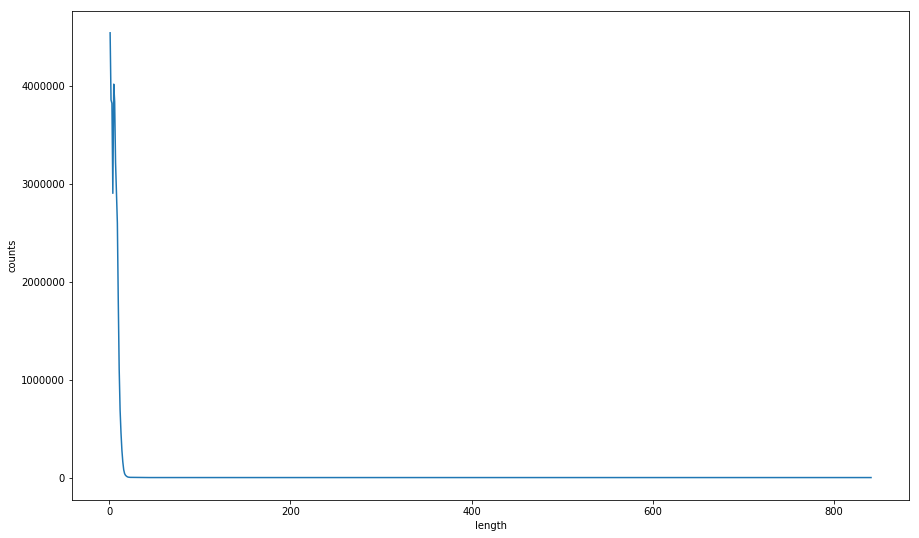

In [36]:
#Выведем график длин слов - количество слов заданной длинны
rcParams['figure.figsize'] = 15,9
length = [k for k in length_counts]
counts = [length_counts[k] for k in length_counts]

y_pos = maxkey
 
plt.plot(length, counts, label='Texts lengths')
plt.xlabel('length')
plt.ylabel('counts')

plt.show()

In [38]:
#Создаем словари в котором в качестве ключа будет длинна текста в символах или слоава, а в качестве значений, к
#количествоо текстов такой длинны
text_word_lengths={}
text_symbol_lengths={}
words={}

for response in responses:
    r=response['text']
    symbol_length=len(r)
    text_symbol_lengths[symbol_length]=text_symbol_lengths.get(symbol_length, 0)+1
    k=r.split()
    word_length=len(k)
    text_word_lengths[word_length]=text_word_lengths.get(word_length, 0)+1

length_counts={}
#Выведем отсортированный словарь длин слов и количество слов такой длинны
for k in sorted(text_symbol_lengths.keys()):
    length_counts[k]=text_symbol_lengths[k]
    col+=1
    maxkey=k
    print(k, ':', text_symbol_lengths[k])

23 : 1
31 : 1
35 : 1
36 : 1
39 : 1
41 : 2
45 : 2
46 : 1
48 : 2
52 : 1
53 : 1
54 : 1
56 : 3
58 : 1
59 : 1
61 : 1
62 : 1
63 : 1
65 : 1
66 : 3
69 : 3
70 : 2
71 : 1
72 : 3
74 : 1
75 : 4
76 : 1
77 : 4
78 : 3
79 : 3
80 : 2
81 : 3
82 : 3
83 : 2
85 : 2
86 : 2
87 : 4
88 : 2
89 : 1
90 : 5
91 : 2
92 : 2
94 : 3
96 : 3
97 : 3
98 : 4
101 : 2
102 : 2
103 : 2
104 : 2
105 : 1
106 : 4
107 : 1
108 : 4
109 : 2
110 : 3
111 : 2
113 : 1
114 : 2
115 : 1
116 : 1
117 : 2
118 : 3
119 : 1
120 : 1
121 : 1
122 : 2
123 : 6
124 : 6
125 : 4
126 : 5
127 : 4
128 : 1
129 : 1
130 : 4
131 : 7
132 : 2
133 : 3
134 : 1
135 : 4
136 : 6
137 : 3
138 : 4
139 : 3
140 : 6
141 : 3
142 : 6
143 : 8
144 : 5
145 : 4
146 : 3
147 : 6
148 : 6
149 : 5
151 : 4
152 : 6
153 : 5
154 : 2
155 : 5
156 : 5
157 : 4
158 : 2
159 : 5
160 : 8
161 : 5
162 : 4
163 : 4
164 : 4
165 : 11
166 : 3
167 : 8
168 : 5
169 : 4
170 : 2
171 : 7
172 : 4
173 : 7
174 : 6
175 : 8
176 : 5
177 : 7
178 : 6
179 : 8
180 : 12
181 : 10
182 : 4
183 : 6
184 : 7
185 : 7
186 : 6
187

1570 : 47
1571 : 53
1572 : 39
1573 : 50
1574 : 55
1575 : 44
1576 : 63
1577 : 64
1578 : 54
1579 : 43
1580 : 48
1581 : 34
1582 : 63
1583 : 61
1584 : 53
1585 : 40
1586 : 50
1587 : 49
1588 : 44
1589 : 44
1590 : 53
1591 : 39
1592 : 44
1593 : 41
1594 : 43
1595 : 61
1596 : 56
1597 : 52
1598 : 52
1599 : 40
1600 : 49
1601 : 61
1602 : 51
1603 : 49
1604 : 51
1605 : 44
1606 : 48
1607 : 41
1608 : 39
1609 : 43
1610 : 51
1611 : 57
1612 : 48
1613 : 47
1614 : 38
1615 : 35
1616 : 51
1617 : 47
1618 : 59
1619 : 52
1620 : 40
1621 : 52
1622 : 49
1623 : 50
1624 : 41
1625 : 48
1626 : 45
1627 : 45
1628 : 46
1629 : 44
1630 : 43
1631 : 57
1632 : 42
1633 : 43
1634 : 56
1635 : 37
1636 : 50
1637 : 57
1638 : 34
1639 : 46
1640 : 52
1641 : 50
1642 : 49
1643 : 61
1644 : 53
1645 : 48
1646 : 42
1647 : 52
1648 : 49
1649 : 42
1650 : 51
1651 : 38
1652 : 40
1653 : 46
1654 : 50
1655 : 41
1656 : 58
1657 : 41
1658 : 44
1659 : 55
1660 : 48
1661 : 47
1662 : 50
1663 : 57
1664 : 52
1665 : 49
1666 : 44
1667 : 40
1668 : 42
1669 : 54


3154 : 12
3155 : 11
3156 : 5
3157 : 7
3158 : 10
3159 : 13
3160 : 11
3161 : 10
3162 : 12
3163 : 7
3164 : 10
3165 : 10
3166 : 12
3167 : 14
3168 : 11
3169 : 7
3170 : 10
3171 : 16
3172 : 8
3173 : 9
3174 : 10
3175 : 8
3176 : 5
3177 : 14
3178 : 7
3179 : 13
3180 : 10
3181 : 14
3182 : 9
3183 : 13
3184 : 11
3185 : 11
3186 : 15
3187 : 8
3188 : 6
3189 : 10
3190 : 15
3191 : 6
3192 : 10
3193 : 13
3194 : 8
3195 : 10
3196 : 14
3197 : 10
3198 : 15
3199 : 15
3200 : 7
3201 : 9
3202 : 11
3203 : 9
3204 : 15
3205 : 8
3206 : 9
3207 : 8
3208 : 11
3209 : 15
3210 : 17
3211 : 10
3212 : 13
3213 : 15
3214 : 14
3215 : 12
3216 : 9
3217 : 11
3218 : 7
3219 : 13
3220 : 8
3221 : 12
3222 : 7
3223 : 9
3224 : 9
3225 : 11
3226 : 6
3227 : 10
3228 : 7
3229 : 7
3230 : 7
3231 : 10
3232 : 6
3233 : 9
3234 : 10
3235 : 10
3236 : 17
3237 : 7
3238 : 7
3239 : 10
3240 : 9
3241 : 8
3242 : 8
3243 : 11
3244 : 8
3245 : 10
3246 : 16
3247 : 9
3248 : 7
3249 : 6
3250 : 8
3251 : 7
3252 : 5
3253 : 8
3254 : 8
3255 : 7
3256 : 15
3257 : 12
3258 : 

4906 : 1
4907 : 2
4908 : 4
4909 : 4
4910 : 2
4911 : 3
4912 : 4
4914 : 1
4915 : 1
4916 : 1
4917 : 1
4919 : 1
4920 : 4
4921 : 1
4922 : 3
4923 : 3
4924 : 2
4925 : 3
4926 : 2
4927 : 3
4928 : 6
4929 : 5
4930 : 1
4931 : 2
4932 : 4
4933 : 2
4934 : 3
4935 : 1
4936 : 3
4937 : 2
4938 : 1
4939 : 4
4940 : 1
4941 : 3
4942 : 3
4943 : 3
4944 : 3
4946 : 3
4947 : 4
4948 : 4
4949 : 1
4950 : 2
4951 : 1
4952 : 3
4953 : 1
4954 : 2
4955 : 3
4956 : 1
4957 : 4
4958 : 1
4960 : 3
4961 : 3
4962 : 2
4963 : 3
4964 : 4
4967 : 1
4968 : 1
4969 : 2
4970 : 1
4971 : 3
4972 : 2
4973 : 2
4974 : 2
4975 : 3
4976 : 1
4977 : 3
4978 : 5
4979 : 3
4980 : 3
4981 : 2
4982 : 2
4983 : 4
4984 : 4
4985 : 1
4986 : 2
4987 : 2
4988 : 1
4989 : 4
4990 : 2
4991 : 4
4992 : 4
4993 : 2
4994 : 2
4995 : 1
4996 : 4
4997 : 1
4998 : 2
4999 : 6
5000 : 2
5001 : 1
5004 : 1
5007 : 3
5008 : 1
5009 : 2
5011 : 3
5012 : 1
5013 : 1
5015 : 2
5016 : 5
5018 : 2
5019 : 6
5020 : 1
5021 : 5
5023 : 5
5024 : 2
5025 : 6
5027 : 5
5028 : 2
5029 : 1
5030 : 1
5031 : 2
5

7790 : 1
7791 : 1
7795 : 1
7798 : 1
7799 : 1
7802 : 2
7804 : 1
7805 : 1
7806 : 1
7807 : 1
7810 : 1
7811 : 1
7812 : 2
7825 : 2
7827 : 1
7828 : 1
7829 : 1
7833 : 1
7839 : 1
7843 : 1
7845 : 1
7847 : 1
7848 : 1
7849 : 1
7853 : 3
7863 : 1
7871 : 1
7872 : 1
7875 : 1
7890 : 1
7891 : 2
7895 : 1
7897 : 1
7901 : 1
7903 : 1
7909 : 1
7910 : 1
7913 : 1
7917 : 1
7918 : 1
7919 : 1
7921 : 1
7923 : 1
7930 : 1
7932 : 1
7934 : 1
7938 : 1
7940 : 1
7941 : 1
7943 : 1
7945 : 1
7950 : 1
7951 : 1
7953 : 1
7954 : 2
7956 : 1
7960 : 1
7968 : 1
7969 : 1
7970 : 1
7971 : 1
7972 : 1
7978 : 2
7984 : 1
7985 : 1
7997 : 1
7998 : 1
8000 : 1
8002 : 1
8003 : 1
8004 : 1
8005 : 1
8007 : 1
8009 : 1
8018 : 2
8026 : 1
8029 : 2
8032 : 2
8039 : 1
8043 : 1
8049 : 1
8052 : 2
8057 : 2
8069 : 1
8074 : 1
8075 : 1
8076 : 1
8077 : 1
8081 : 1
8085 : 1
8087 : 1
8090 : 1
8091 : 1
8093 : 1
8098 : 2
8099 : 1
8100 : 1
8108 : 1
8111 : 1
8113 : 1
8115 : 1
8117 : 1
8120 : 1
8121 : 1
8129 : 1
8132 : 1
8133 : 2
8134 : 2
8135 : 1
8145 : 2
8148 : 1
8

(array([  3.01500000e+03,   6.05000000e+02,   5.87000000e+02,
          2.62000000e+02,   1.94000000e+02,   2.48000000e+02,
          1.15000000e+02,   1.22000000e+02,   1.51000000e+02,
          9.00000000e+01,   9.20000000e+01,   1.09000000e+02,
          6.60000000e+01,   4.70000000e+01,   6.50000000e+01,
          5.40000000e+01,   5.80000000e+01,   8.40000000e+01,
          4.60000000e+01,   3.50000000e+01,   6.90000000e+01,
          4.50000000e+01,   3.40000000e+01,   5.60000000e+01,
          3.90000000e+01,   4.50000000e+01,   5.20000000e+01,
          4.70000000e+01,   4.90000000e+01,   7.00000000e+01,
          6.30000000e+01,   6.00000000e+01,   8.90000000e+01,
          7.70000000e+01,   5.70000000e+01,   9.40000000e+01,
          6.40000000e+01,   5.70000000e+01,   6.90000000e+01,
          4.10000000e+01,   3.50000000e+01,   4.80000000e+01,
          2.20000000e+01,   1.40000000e+01,   2.20000000e+01,
          1.00000000e+01,   7.00000000e+00,   0.00000000e+00,
        

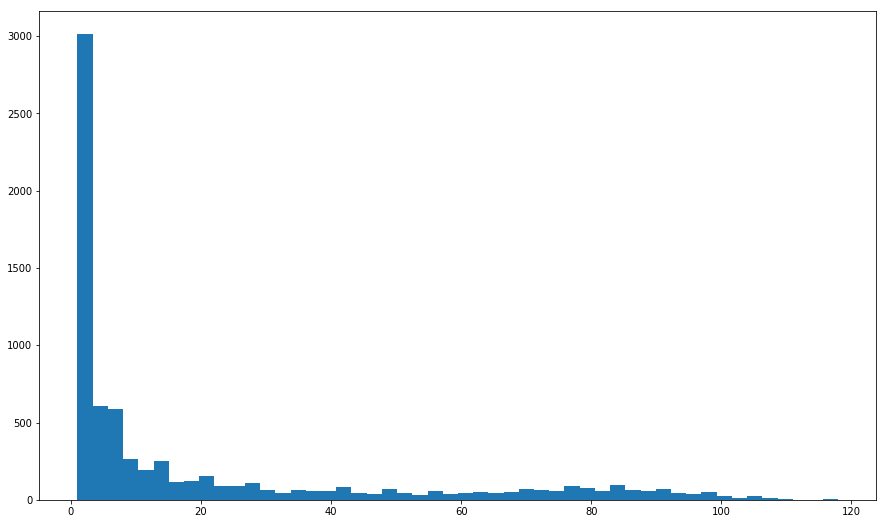

In [43]:
import matplotlib.pyplot as plt
import numpy as np 
from pylab import rcParams
rcParams['figure.figsize'] = 15,9
#Строим гистограмму количества символов в текстах
j = [length_counts[k] for k in length_counts]

plt.hist(j, bins=50)

In [44]:
word_counts={}
#Выведем отсортированный словарь длин слов и количество слов такой длинны
for k in sorted(text_word_lengths.keys()):
    word_counts[k]=text_word_lengths[k]
    col+=1
    maxkey=k
    print(k, ':', text_word_lengths[k])

1 : 1
4 : 2
5 : 2
6 : 3
7 : 3
8 : 7
9 : 10
10 : 19
11 : 10
12 : 11
13 : 14
14 : 12
15 : 15
16 : 10
17 : 16
18 : 13
19 : 26
20 : 34
21 : 27
22 : 33
23 : 33
24 : 28
25 : 32
26 : 40
27 : 47
28 : 50
29 : 57
30 : 63
31 : 49
32 : 63
33 : 59
34 : 67
35 : 75
36 : 73
37 : 75
38 : 99
39 : 108
40 : 128
41 : 150
42 : 196
43 : 245
44 : 290
45 : 330
46 : 372
47 : 399
48 : 460
49 : 433
50 : 482
51 : 518
52 : 502
53 : 485
54 : 487
55 : 535
56 : 496
57 : 519
58 : 477
59 : 470
60 : 481
61 : 470
62 : 483
63 : 474
64 : 484
65 : 525
66 : 517
67 : 533
68 : 469
69 : 504
70 : 522
71 : 541
72 : 525
73 : 545
74 : 559
75 : 546
76 : 544
77 : 543
78 : 600
79 : 562
80 : 586
81 : 585
82 : 555
83 : 589
84 : 556
85 : 588
86 : 560
87 : 580
88 : 585
89 : 586
90 : 629
91 : 591
92 : 598
93 : 562
94 : 580
95 : 593
96 : 583
97 : 640
98 : 587
99 : 586
100 : 626
101 : 633
102 : 601
103 : 582
104 : 624
105 : 594
106 : 574
107 : 616
108 : 598
109 : 598
110 : 613
111 : 608
112 : 619
113 : 571
114 : 613
115 : 591
116 : 580
117 : 

1459 : 3
1461 : 2
1462 : 1
1463 : 4
1464 : 1
1466 : 1
1467 : 1
1468 : 1
1469 : 3
1470 : 1
1472 : 1
1473 : 1
1475 : 1
1476 : 1
1477 : 2
1478 : 1
1479 : 2
1482 : 1
1483 : 1
1486 : 1
1487 : 1
1488 : 1
1489 : 1
1490 : 1
1491 : 1
1492 : 1
1493 : 1
1496 : 1
1497 : 1
1498 : 1
1499 : 1
1501 : 1
1503 : 2
1505 : 1
1506 : 1
1510 : 1
1513 : 1
1514 : 1
1516 : 1
1517 : 2
1519 : 3
1521 : 2
1523 : 1
1526 : 2
1527 : 1
1529 : 1
1532 : 1
1533 : 1
1534 : 1
1535 : 2
1536 : 1
1538 : 1
1539 : 2
1543 : 1
1545 : 1
1546 : 1
1548 : 1
1549 : 1
1551 : 3
1553 : 2
1555 : 1
1556 : 1
1557 : 1
1558 : 2
1559 : 1
1561 : 3
1562 : 1
1564 : 1
1566 : 2
1567 : 3
1571 : 1
1572 : 1
1573 : 1
1574 : 2
1576 : 1
1577 : 1
1578 : 2
1579 : 1
1581 : 1
1582 : 2
1584 : 1
1586 : 1
1588 : 1
1592 : 1
1595 : 2
1596 : 1
1597 : 1
1598 : 1
1600 : 1
1601 : 1
1602 : 1
1605 : 1
1607 : 2
1608 : 1
1611 : 1
1613 : 1
1615 : 2
1616 : 1
1617 : 1
1622 : 1
1623 : 1
1624 : 3
1628 : 1
1633 : 1
1636 : 1
1642 : 2
1643 : 1
1645 : 1
1646 : 1
1648 : 1
1650 : 1
1

(array([ 949.,  139.,   76.,   59.,   39.,   39.,   24.,   16.,   21.,
          17.,   16.,   17.,   14.,   12.,    5.,   12.,    8.,    9.,
          12.,    2.,    7.,   10.,    7.,    9.,    5.,   10.,    4.,
           4.,    5.,    4.,    9.,    5.,    9.,    6.,    2.,    4.,
          10.,   12.,    7.,   11.,   10.,   12.,    9.,   10.,   11.,
          18.,   15.,    5.,    4.,    4.]),
 array([   1.  ,   13.78,   26.56,   39.34,   52.12,   64.9 ,   77.68,
          90.46,  103.24,  116.02,  128.8 ,  141.58,  154.36,  167.14,
         179.92,  192.7 ,  205.48,  218.26,  231.04,  243.82,  256.6 ,
         269.38,  282.16,  294.94,  307.72,  320.5 ,  333.28,  346.06,
         358.84,  371.62,  384.4 ,  397.18,  409.96,  422.74,  435.52,
         448.3 ,  461.08,  473.86,  486.64,  499.42,  512.2 ,  524.98,
         537.76,  550.54,  563.32,  576.1 ,  588.88,  601.66,  614.44,
         627.22,  640.  ]),
 <a list of 50 Patch objects>)

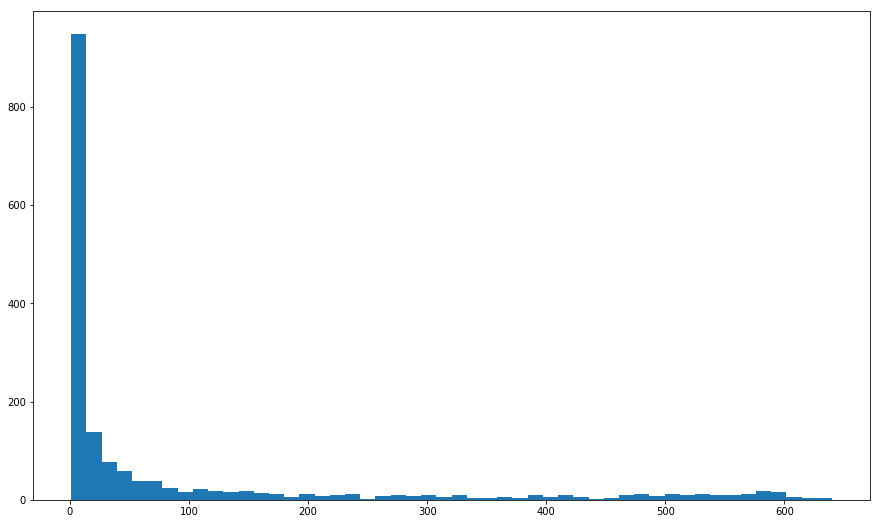

In [45]:
#Строим гистограмму количества слов в текстах
j = [word_counts[k] for k in word_counts]

plt.hist(j, bins=50)

### Самые часто встречающиеся слова

In [10]:
fulltext = []
for response in tqdm(responses):
    fulltext+=response['text'].split()


100%|██████████| 153499/153499 [00:08<00:00, 17722.55it/s]


In [11]:
from nltk import FreqDist
fd = FreqDist(fulltext)
for i in fd.most_common(10):
    print(i)

('в', 1157262)
('и', 965735)
('не', 808409)
('на', 632541)
('что', 586864)
('я', 427944)
('с', 423586)
('по', 333342)
('-', 294086)
('мне', 277035)


### Самые часто встречающиеся слова без стоп слов

In [18]:
#Импортируем имеющийся корпус стоп-слов из nltk
from nltk.corpus import stopwords

#Добавляем несколько своих стои-слов
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', '-']

#Оописываем функцию удаления стоп-слов
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [19]:
print(mystopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [23]:
from pymystem3 import Mystem
m = Mystem()

#Описываем функцию лематизации текста
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [24]:
#Разбиваем текст на слова, слова приводим к нижнему регистру, лематизируем и выбрасываем стпо-слова
fulltext = []
for response in tqdm(responses):
    r=response['text'].lower()
    r=lemmatize(r)
    r=remove_stopwords(r)
    fulltext+=r.split()

100%|██████████| 153499/153499 [27:25<00:00, 93.28it/s]


In [25]:
#Выводим список самых популярных слов без стоп-слов
fd = FreqDist(fulltext)
for i in fd.most_common(10):
    print(i)

('банк', 366418)
('карта', 219721)
('который', 142653)
('весь', 134852)
('деньги', 128575)
('свой', 115251)
('отделение', 109286)
('сотрудник', 109254)
('мочь', 104817)
('банк,', 102983)


### Топ 10 самыс популчрных существительных

Среди найденных самых популярных слов отбираем существительные и выводим их. При достижении заданного количества - заканчиваем.

In [31]:
import re
fd150=fd.most_common(150)
j=0
maxcoun=10
for i in fd150:
    #k=m.analyze(i[0])
    k=m.analyze(i[0])[0]['analysis'][0]['gr']
    if re.match('S,', k):
        print(i)
        j+=1
        if j==maxcount:
            break

('банк', 366418)
('карта', 219721)
('деньги', 128575)
('отделение', 109286)
('сотрудник', 109254)
('мочь', 104817)
('банк,', 102983)
('счет', 95038)
('кредит', 94561)
('день', 93713)


### Самые частые слова

### Закон Ципфа

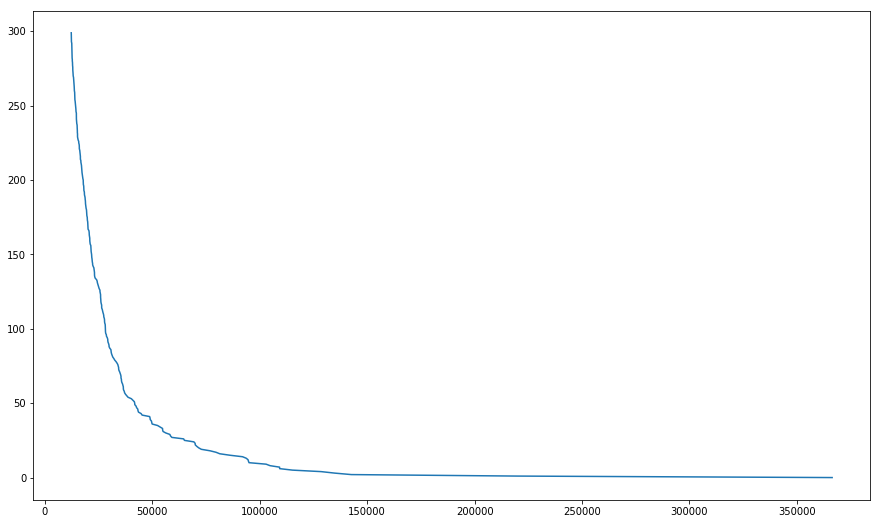

In [46]:
freqs = list(fd.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [54]:
print(fd['сотрудник'], fd['клиент'])

109254 81409


In [55]:
#Слово сотрудник встречается чаще, чем слово клиент

In [56]:
print(fd['мошенничество'], fd['доверие'])

1429 1440


In [ ]:
#Слово "мошенничество" встречается 1429 раз, "доверие" встречается 1440 раз

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


NameError: name 'CountVectorizer' is not defined